# Hot off the press from chatgpt o3-mini-high

In [1]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd
from generative_RBM import GenerativeRBM

In [6]:
DATA_PATH = '../Matrix2_filtered_and_downsampled_1March2025.csv'

In [7]:
# ----------------------------------------------------------------
# Demonstration code:
def demo_generative_rbm(epochs=10):

    # Create the RBM instance.
    rbm = GenerativeRBM(n_hidden=128)

    # Train the RBM.
    losses, samples = rbm.fit(rbm.X_train, epochs=epochs, batch_size=64, learning_rate=0.01, k=1, l2_reg=0.001)
    # Reconstruct test samples.
    test_samples = rbm.X_test[:, :10]
    v_recon = rbm.reconstruct(test_samples)

    # Plot original and reconstructed images.
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(np.array(test_samples[:, i]).reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(np.array(v_recon[:, i]).reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")
    plt.suptitle("Top: Original | Bottom: Reconstruction")
    plt.show()

    # Generate new samples.
    generated_samples = rbm.generate(n_samples=10, gibbs_steps=100)
    fig, axes = plt.subplots(1, 10, figsize=(10, 1))
    for i in range(10):
        axes[i].imshow(np.array(generated_samples[:, i]).reshape(28, 28), cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Newly Generated Samples")
    plt.show()
    return rbm, losses, samples 

# To run the demonstration, simply call:
# demo_generative_rbm()


P = 2
rbm, losses, samples = demo_generative_rbm(epochs=5) 

In [12]:
rbm = GenerativeRBM(n_hidden=128, data_path=DATA_PATH) 

Epoch 0/2, Reconstruction Loss: 406772.0000
Epoch 1/2, Reconstruction Loss: 318909.0000


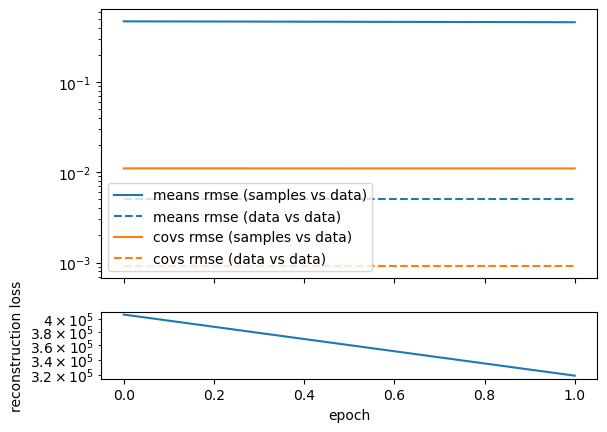

In [15]:
train_args = {'X_train': rbm.X_train, 
              'epochs': 2, 
              'batch_size': 64, 
              'learning_rate': 0.01, 
              'k': 1, 
              'l2_reg': 0.0, 
              'sample_number': 1000}

fig, axs, samples, err = rbm.plot_deviations_over_time(train_args)